In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
X,y=load_boston().data,load_boston().target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [2]:
from sklearn.linear_model import LinearRegression as sklearn_lr
model=sklearn_lr().fit(X_train,y_train)
print(model.coef_)
print(model.intercept_)

[-1.19726335e-01  5.65988993e-02 -1.84206207e-02  3.42296323e+00
 -1.84799319e+01  3.46865075e+00  1.96811784e-02 -1.62153041e+00
  3.67369693e-01 -1.25749610e-02 -1.03820109e+00  1.02757121e-02
 -5.95518239e-01]
40.40341729474642


In [3]:
model.predict(X_test)[:10]

array([11.9539991 , 37.29066182, 12.80936221, 21.9002029 , 24.30231677,
       19.95930151, 27.2244878 , 17.22401073, 16.0358917 , 18.67457325])

### 1.使用Scipy optimize求解线性回归

In [4]:
from scipy.optimize import lsq_linear
class LinearRegression:
    def fit(self,X,y):
        _,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        A = X
        b = y
        res = lsq_linear(A, b, lsmr_tol='auto', verbose=1)
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        self.res=res
        return self
    def predict(self,X):
        return np.array(X@self.coef_.reshape(-1,1)+self.intercept_).flatten()
           
model=LinearRegression().fit(X_train,y_train)
model.predict(X_test)[:5]

The unconstrained solution is optimal.
Final cost 4.1261e+03, first-order optimality 6.11e-09


array([11.9539991 , 37.29066182, 12.80936221, 21.9002029 , 24.30231677])

### 3.使用Scipy求解带L2正则化的线性回归

In [5]:
def loss(w,X,y,c=0.1):
    _,n=np.shape(X)
    X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量                                                 
    loss=np.square(y-X@w).sum()+c*np.square(w[:-1]).sum()    #minmize ||y - Xw||^2_2 + alpha * ||w||^2_2
    return loss

In [6]:
class Ridge:
    def __init__(self,c=0.0001):
        self.c=c
    def fit(self,X,y):
        init_w=np.random.randn(X.shape[1]+1)
        res=minimize(loss,init_w,args=(X,y))
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        return self
    def predict(self,X):
        pred=X@self.coef_.T+self.intercept_
        regularization=self.c*self.coef_.T@self.coef_
        return pred+regularization
model=Ridge().fit(X_train,y_train)
pre=model.predict(X_test)
pre[:10]

array([12.2236093 , 37.40258523, 12.82581317, 21.97843787, 24.51227418,
       20.0039469 , 27.27949901, 17.27185042, 16.26276704, 18.81287885])

In [7]:
from sklearn.linear_model import Ridge as sklearn_Ridge
model=sklearn_Ridge(alpha=0.0001).fit(X_train,y_train)
pre2=model.predict(X_test)
pre2[:10]

array([11.95425932, 37.29074957, 12.80934583, 21.90025437, 24.3025132 ,
       19.95931603, 27.22451349, 17.22402859, 16.03610534, 18.67469024])

### 3.使用梯度下降法求解线性回归

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=50):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            error=X@W.T-y
            grad=(2*X.T@error)/m
            W=W-self.learning_rate*grad  #更新权重
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='black')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

4.2219760078790404e-05

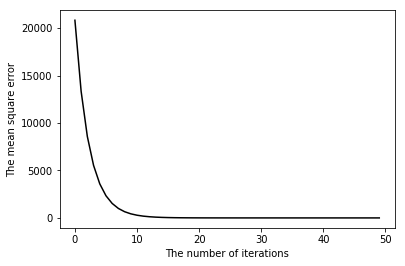

In [9]:
from sklearn.datasets import make_regression
X,y=make_regression(n_features=10,n_samples=1000)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))

### 4.使用随机梯度下降法

In [18]:
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=100):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            dataIndex=list(range(m))
            for j in range(m):
                alpha = 4/(1.0+j+i)+0.001   
                randIndex = int(np.random.uniform(0,len(dataIndex)))  #随机挑选一个样本进行迭代                       
                error=X[randIndex]@W.T-y[randIndex]
                grad=(X[randIndex].T*error)/m
                W=W-self.learning_rate*grad  #更新权重
                del (dataIndex[randIndex])
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='black')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

0.0004403489908882859

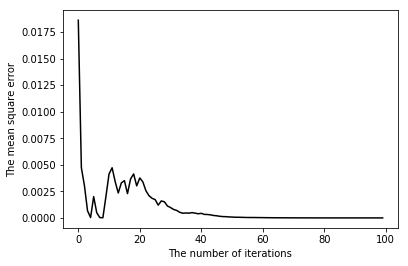

In [19]:
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))